# Import

In [27]:
import numpy as np

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch.utils.data import Dataset
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinarySpecificity
from torchmetrics.classification import BinaryAUROC
from torchmetrics.classification import BinaryAccuracy

 # DataSet & DataLoader preparation


## Dataset

In [28]:
class DatasetPTBXL(Dataset):

    def __init__(self, path,p_list,p_name):
        self.path = path
        self.len = len(os.listdir(self.path))
        self.target_list = p_list
        self.target_name = p_name
    def __len__(self):
        return self.len


    def __getitem__(self, idx):
        file = np.load(path + str(idx) + '.npy', allow_pickle=True).item()
        return torch.from_numpy(file['data']), torch.from_numpy(file['target'][ptlg_list.index(ptlg_name)])

## Inputs

In [29]:
path = '/home/narmarinad_12/Desktop/ECG/files_processed/'
ptlg_list = ['SR', 'AFIB', 'STACH', 'SARRH', 'SBRAD', 'PACE', 'SVARR', 'BIGU', 'AFLT', 'SVTAC', 'PSVT', 'TRIGU']
ptlg_name = 'SR'


## Split and DataLoad

In [40]:
train_dataset = DatasetPTBXL(path,ptlg_list,ptlg_name)

tmp_len = len(train_dataset)
train_size = int (0.8 * tmp_len) 
valid_size = int (0.1 * tmp_len)
test_size = tmp_len - train_size - valid_size

train_dataset, valid_dataset,test_dataset = random_split(train_dataset, [train_size, valid_size, test_size])                                                                       
batch_size = 500
train_dataset = DataLoader(train_dataset, batch_size, num_workers = 5, pin_memory = True ) 
valid_dataset = DataLoader(valid_dataset, batch_size, num_workers = 5, pin_memory = True )
test_dataset  = DataLoader(test_dataset , batch_size, num_workers = 5, pin_memory = True )

# Model

 



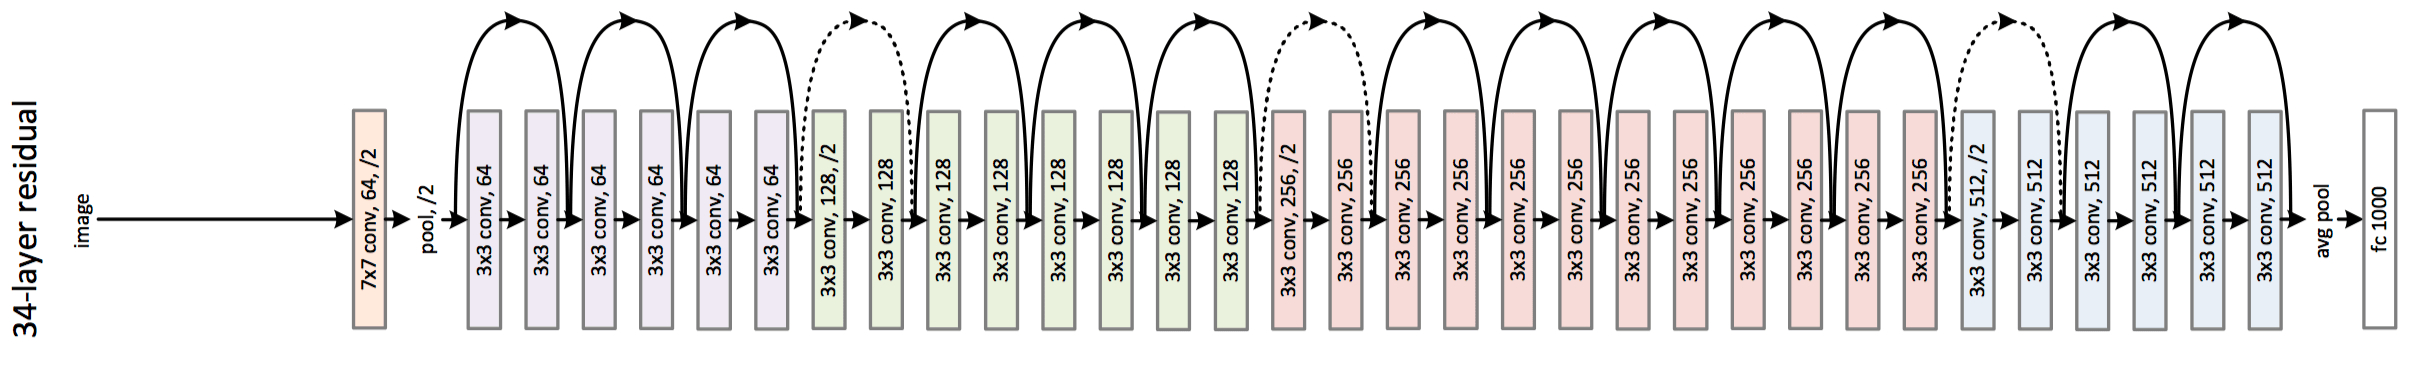


In [41]:
class RhythmECGClassification(nn.Module):
    
    def __init__(self, in_channels):
        
        super(RhythmECGClassification, self).__init__()
        
        self.in_channels = in_channels
        
        self.relu = nn.ReLU()        
        
        self.block0 = nn.Sequential(nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3),
                                    nn.BatchNorm1d(64), 
                                    nn.ReLU(), nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
        
        self.block1 = nn.Sequential(nn.Conv1d(64,64, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(64),
                                    nn.ReLU(),
                                    nn.Conv1d(64,64, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(64))
        
        self.block2 = nn.Sequential(nn.Conv1d(64,128, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(128),
                                    nn.ReLU(),
                                    nn.Conv1d(128,128, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(128))
        
        self.block3 = nn.Sequential(nn.Conv1d(128,128, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(128),
                                    nn.ReLU(),
                                    nn.Conv1d(128,128, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(128))
        
        self.block4 = nn.Sequential(nn.Conv1d(128,256, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(),
                                    nn.Conv1d(256,256, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(256))
        
        self.block5 = nn.Sequential(nn.Conv1d(256,256, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(),
                                    nn.Conv1d(256,256, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(256))
        
        self.block6 = nn.Sequential(nn.Conv1d(256,512, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(),
                                    nn.Conv1d(512,512, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(512))
        
        self.block7 = nn.Sequential(nn.Conv1d(512,512, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(),
                                    nn.Conv1d(512,512, kernel_size = 3, stride = 1, padding = 1), 
                                    nn.BatchNorm1d(512))
        
        self.block8 = nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(),
                                    nn.Dropout(0.2),nn.Linear(512, 1000), nn.ReLU(), 
                                    nn.Linear(1000,1), nn.Sigmoid())
        
        self.ident1 = nn.Sequential(nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1), 
                                    nn.BatchNorm1d(128))
        
        self.ident2 = nn.Sequential(nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1), 
                                    nn.BatchNorm1d(256))
        
        self.ident3 = nn.Sequential(nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1), 
                                    nn.BatchNorm1d(512))
        
     
        
  
        
        
    def forward(self, x):
        
        
        
        x = self.block0(x)
        
        for i in range (3):
            identity = x
            x = self.block1(x) + identity
            x = self.relu(x)
            
        identity = self.ident1(x)
        x = self.block2(x) + identity
        x = self.relu(x)
        
        for i in range (3):
            identity = x
            x = self.block3(x) + identity
            x = self.relu(x)
        
        identity = self.ident2(x)
        x = self.block4(x) + identity
        x = self.relu(x)
        
        for i in range (5):
            identity = x
            x = self.block5(x) + identity
            x = self.relu(x)
        
        identity = self.ident3(x)
        x = self.block6(x) + identity
        x = self.relu(x)
        
        for i in range (2):
            identity = x
            x = self.block7(x) + identity
            x = self.relu(x)
        return x 
    
   
    def training_step(self,batch):
        signals,targets = batch
        preds = self((signals.float())) 
        loss = nn.BCELoss()
        return loss(preds, targets)
    

    def validation_step(self,batch):
        signals,targets = batch
        preds = self((signals.float()))
        return { 'batch_preds': preds.detach(), 'batch_targets': targets}

# 3. Оценивание
    
    





In [ ]:
#calculating metrics of epoch, returning dict of metrics
def evaluate(model, valid_dataset,device):
  model.eval()
  metric_F1 = BinaryF1Score().to(device)
  metric_Rec = BinaryRecall().to(device)
  metric_Spec = BinarySpecificity().to(device)
  metric_AUC = BinaryAUROC(thresholds=None).to(device)
  metric_Acc = BinaryAccuracy().to(device)
  with torch.no_grad():
    for batch in valid_dataset:
      tmp = model.validation_step(batch)
      metric_F1(tmp['batch_preds'], tmp['batch_targets'] )
      metric_Rec(tmp['batch_preds'], tmp['batch_targets'] )
      metric_Spec(tmp['batch_preds'], tmp['batch_targets'] )
      metric_AUC(tmp['batch_preds'], tmp['batch_targets'] )
      metric_Acc(tmp['batch_preds'], tmp['batch_targets'] )


  
  return {'model_acc': metric_Acc.compute().item(),'model_F1score': metric_F1.compute().item(),'model_Recall': metric_Rec.compute().item(),
          'model_Specificity': metric_Spec.compute().item(), 'model_ROCAUC': metric_AUC.compute().item() }


In [ ]:
#ploting metrics/epoch
import matplotlib.pyplot as plt

def visual_res(history, epoch_num ):
  plt.title('Динамика обучения') 
  plt.xlabel('Эпоха')
  plt.ylabel('Метрика')
  
  
  # list_of_metrics содержит наборы значений метрик для построения графика метрика/номер эпохи
  plt.plot(list(range(epoch_num)), [x['model_F1score'] for x in history],label = 'F1')
  plt.plot(list(range(epoch_num)), [x['model_Recall'] for x in history],label = 'Recall')
  plt.plot(list(range(epoch_num)), [x['model_Specificity'] for x in history], label = 'Specificity')
  plt.plot(list(range(epoch_num)), [x['model_ROCAUC'] for x in history], label = 'AUC')
  plt.plot(list(range(epoch_num)), [x['model_acc'] for x in history], label = 'Acc')
  # plt.plot(list(range(epoch_num)), [x['epoch_loss'] for x in history], label = 'loss')
  plt.grid(True)
  plt.legend()
  #построение графиков

# 4. Использование GPU

In [ ]:

def get_default_device():
    if torch.cuda.is_available(): return torch.device('cuda')
    else: return torch.device('cpu')
 
def to_device(data, device):
  if isinstance(data, (list)): return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  
#creating generator for batch to gpu
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
        
device = get_default_device()
train_dataset = DeviceDataLoader(train_dataset, device)
valid_dataset = DeviceDataLoader(valid_dataset, device)
test_dataset = DeviceDataLoader(test_dataset, device)

# 5. Функция тренировки модели
    Сохраняем метрики и динамику функции потерь для каждой эпохи в переменной history.


In [ ]:
def fit(epoch_num, lr, model, gc, wd ,opt,device,key):
  
  patallogies = {0: 'sinus_rhythm', 1: 'atrial_fibrillation',2: 'sinus tachycardia',
                 3: 'sinus arrhythmia', 4: 'sinus_bradycardia'}

  opt = opt(model.parameters(), lr, weight_decay = wd )
  history = []
  #for every epoch we will save model in Model.dir
  #later we will chose one with better scores
  for epoch in range(epoch_num):
    torch.cuda.empty_cache()
    model.train()
    train_losses = 0
    for batch in train_dataset:
      loss = model.training_step(batch) 
      train_losses/=2
      train_losses+=loss.detach()
      loss.backward()
      nn.utils.clip_grad_value_(model.parameters(), gc)
      opt.step()
      opt.zero_grad()
      
    result = evaluate(model, valid_dataset,device)
    history.append(result)

    print('Epoch ', epoch,end = "")
    print(': train_loss = %.4f'%train_losses)

    PATH = f'/content/drive/My Drive/ColabNotebooks/ECG/Model1/{patallogies[key]}{epoch}.pth'
    torch.save(model.state_dict(), PATH)
  return history


def train_model(res, lr, epochs,  device,key_t, opt_func = torch.optim.Adam):

  history = []
  model = res
  history += fit(epochs, lr, model, gc, wd, opt_func,device,key_t)
  visual_res(history,epochs)
  
  return model

# 6. Тренировка модели


In [ ]:
lr = 0.1
epochs = 1
gc = 0.1
wd = 0.01
pat = 3

In [ ]:
res = to_device(RhythmECGClassification(12,1,pat,device), device)

In [ ]:
res = train_model(res, lr,epochs,device, pat)
eval = evaluate(res, test_dataset,device)
for keys in eval:
    print(keys, '=' ,eval[keys])

# 7. Результат. Загрузка модели.

In [ ]:
general_metrics = {}
general_metrics1 = {}
patallogies = {0: 'sinus_rhythm', 1: 'atrial_fibrillation',2: 'sinus tachycardia',
                 3: 'sinus arrhythmia', 4: 'sinus_bradycardia'}

In [ ]:
word = 'sinus_bradycardia1'
PATH = f'/content/drive/My Drive/ColabNotebooks/ECG/Model1/{word}.pth'
res = to_device(RhythmECGClassification(12,1,4,device), device)
res.load_state_dict(torch.load(PATH))
# print(the_model)
eval = evaluate(res, test_dataset,device)
for keys in eval:
    print(keys, '=' ,eval[keys])
general_metrics[word] = eval


model_acc = 0.9708113074302673
model_F1score = 0.0
model_Recall = 0.0
model_Specificity = 1.0
model_ROCAUC = 0.6421321630477905


In [ ]:
general_metrics

{'sinus_rhythm1': {'model_acc': 0.833371639251709,
  'model_F1score': 0.9030100107192993,
  'model_Recall': 0.9944018721580505,
  'model_Specificity': 0.2622779607772827,
  'model_ROCAUC': 0.8836913108825684},
 'atrial_fibrillation18': {'model_acc': 0.7692484259605408,
  'model_F1score': 0.370138019323349,
  'model_Recall': 1.0,
  'model_Specificity': 0.7524654865264893,
  'model_ROCAUC': 0.9929792284965515},
 'sinus tachycardia4': {'model_acc': 0.9820730686187744,
  'model_F1score': 0.7845304012298584,
  'model_Recall': 0.9161290526390076,
  'model_Specificity': 0.9845090508460999,
  'model_ROCAUC': 0.9910898208618164},
 'sinus arrhythmia5': {'model_acc': 0.9680533409118652,
  'model_F1score': 0.0,
  'model_Recall': 0.0,
  'model_Specificity': 1.0,
  'model_ROCAUC': 0.5116299986839294},
 'sinus_bradycardia1': {'model_acc': 0.9708113074302673,
  'model_F1score': 0.0,
  'model_Recall': 0.0,
  'model_Specificity': 1.0,
  'model_ROCAUC': 0.6421321630477905}}

# Тесты и итоговые метрики